# NYC Green Taxi Trip Analysis

## Importing Libraries

In [66]:
# Importing Basic Libraries
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import pyarrow.parquet as pq  # Parquet file handling
import seaborn as sns  # Data visualization
import matplotlib as map  # Plotting utilities
import matplotlib.pyplot as plt  # Plotting library
import datetime as dt  # Date and time operations

# Importing all the models and all dependent libraries.
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.pipeline import Pipeline  # Building pipelines
from sklearn.preprocessing import OneHotEncoder  # Encoding categorical data
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
import sklearn.linear_model as lm  # Linear models
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor  # Decision Tree Regressor
from sklearn.neighbors import KNeighborsRegressor  # K-Nearest Neighbors Regressor
from sklearn.linear_model import Lasso  # Lasso Regression
from sklearn.linear_model import Ridge  # Ridge Regression
from sklearn.ensemble import GradientBoostingRegressor  # Gradient Boosting Regressor
import xgboost as xgb  # XGBoost Regressor
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Regression metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA

import warnings  # Suppressing warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [67]:
import pandas as pd

# Function to read and return trip data from parquet files.
def read_trip_data(file_path):
    try:
        return pd.read_parquet(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# List of file paths to import data.
file_names = [
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-03.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-04.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-05.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-06.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-07.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-08.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-09.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-10.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-11.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-12.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet'
]

# Read data from all files into a list of DataFrames.
dfs = [read_trip_data(file_path) for file_path in file_names]

# Concatenate all DataFrames into a single DataFrame.
combined_df = pd.concat(dfs, ignore_index=True)

# Displaying the shape of the combined dataframe.
print(combined_df.shape)


(908613, 20)


In [68]:
# Path to the taxi zone lookup CSV file
taxizonefilepath = 'taxi+_zone_lookup.csv'

# Reading the CSV file into a DataFrame
taxizone_df = pd.read_csv(taxizonefilepath)

# Printing the shape of the DataFrame (rows, columns)
print(taxizone_df.shape)

(265, 4)


In [69]:
# Path to the holidays CSV file
holidaysfilepath = 'Holidays.csv'

# Reading the CSV file into a DataFrame
holidays_df = pd.read_csv(holidaysfilepath)

# Printing the shape of the DataFrame (rows, columns)
print(holidays_df.shape)

(23, 1)


## Initial Data Distribution Analysis

### 1. Trip Distance

count    908613.000000
mean         78.723221
std        3124.612949
min           0.000000
25%           1.150000
50%           2.000000
75%           3.730000
max      360068.140000
Name: trip_distance, dtype: float64


<Axes: xlabel='trip_distance'>

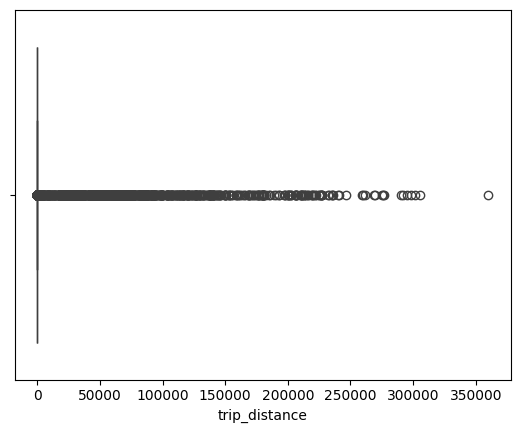

In [70]:
print(combined_df['trip_distance'].describe())
sns.boxplot(x = combined_df['trip_distance'],orient = 'h')

### 2. Fare Amount

count    908613.000000
mean         15.392788
std          15.062441
min        -350.080000
25%           7.900000
50%          11.500000
75%          18.200000
max        2020.200000
Name: fare_amount, dtype: float64


<Axes: xlabel='fare_amount'>

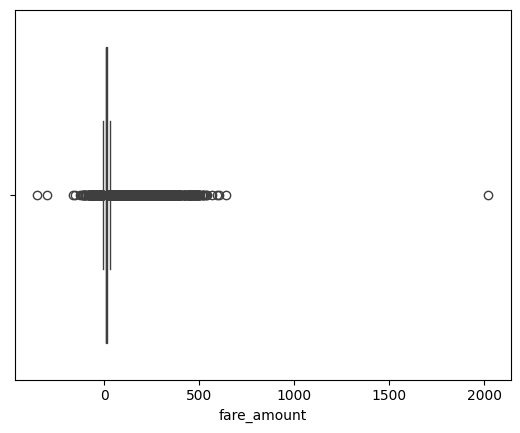

In [71]:
print(combined_df['fare_amount'].describe())
sns.boxplot(combined_df['fare_amount'],orient = 'h')

### 3. Payment Mode

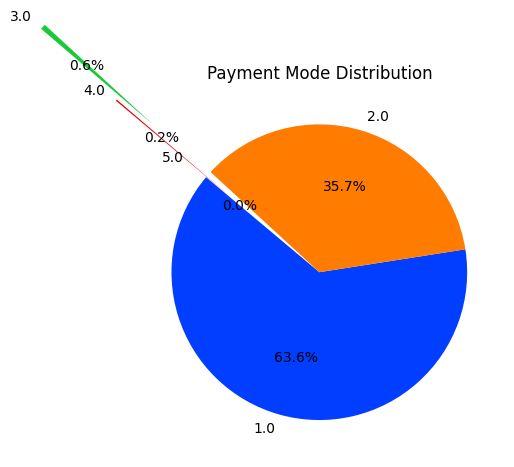

In [72]:
# Calculate value counts of 'payment_type'
payment_mode = combined_df['payment_type'].value_counts().reset_index()

# Rename columns for clarity
payment_mode.columns = ['payment_type', 'count']

# Plotting the pie chart
palette_color = sns.color_palette('bright')
explode = [0, 0, 1.5, 0.8, 0.1]
plt.pie(payment_mode['count'], labels=payment_mode['payment_type'], colors=palette_color, explode=explode, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Payment Mode Distribution')

# Display the pie chart
plt.show()

## Data Preparation and Column

### 1. Taxi Zone Integration


In [73]:
# Pickup Location Zone Merge
combined_df = combined_df.merge(taxizone_df, how='left', left_on='PULocationID', right_on='LocationID')
combined_df.drop(columns=['LocationID'], axis=1, inplace=True)
combined_df.rename(columns={'Borough': 'pickup_borough', 'Zone': 'pickup_zone', 'service_zone': 'pickup_service_zone'}, inplace=True)
print(combined_df.shape)

# Drop-off Location Zone Merge
combined_df = combined_df.merge(taxizone_df, how='left', left_on='DOLocationID', right_on='LocationID')
combined_df.drop(columns=['LocationID'], axis=1, inplace=True)
combined_df.rename(columns={'Borough': 'drop_borough', 'Zone': 'drop_zone', 'service_zone': 'drop_service_zone'}, inplace=True)
print(combined_df.shape)


(908613, 23)
(908613, 26)


### 2. Column Selection and Removal

In [74]:
# Reasons for dropping following columns:
# ehail_fee: this column have 0 records
# passenger_count: As the number of passengers are added by the driver it might be inaccurate.
# store_and_fwd_flag, trip_type, payment_type we are dropping as they are not required for our price prediction.
combined_df.drop(columns=['store_and_fwd_flag', 'ehail_fee', 'trip_type', 'payment_type', 'passenger_count'], inplace=True)

# Dropping all the columns where every single entry is missing.
combined_df.dropna(axis=1, how='all', inplace=True)

print(combined_df.shape)


(908613, 21)


### 3. Column Renaming

In [80]:
#Renaming pickup and dropoff date columns
combined_df = combined_df.rename(columns={'lpep_pickup_datetime': 'pickup_datetime','lpep_dropoff_datetime': 'dropoff_datetime'})

### 4. Trip Filtering

#### a. Trip Distance

In [81]:
print(combined_df.columns)

# Checking corrupted records for 'trip_distance' as it is one of the essential components for our analysis.
print(combined_df.trip_distance.describe())

# To verify and remove records with the distance in negative or 0 miles or more than 100 miles.
combined_df = combined_df[(combined_df['trip_distance'] > 0) & (combined_df['trip_distance'] <= 100)]
print(combined_df.trip_distance.describe())


Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'trip_distance', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'pickup_borough', 'pickup_zone',
       'pickup_service_zone', 'drop_borough', 'drop_zone',
       'drop_service_zone'],
      dtype='object')
count    845964.000000
mean          3.268969
std           3.416941
min           0.010000
25%           1.300000
50%           2.160000
75%           3.900000
max          95.500000
Name: trip_distance, dtype: float64
count    845964.000000
mean          3.268969
std           3.416941
min           0.010000
25%           1.300000
50%           2.160000
75%           3.900000
max          95.500000
Name: trip_distance, dtype: float64


#### b. Fare Amount

In [82]:
# Checking corrupted records for 'fare_amount' as we will be predicting it.
print(combined_df['fare_amount'].describe())

# Filtering all the rows where the amount is less than $3 as it is the base fare.
# Ref for base fare--> https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
combined_df = combined_df[combined_df['fare_amount'] > 3]
print(combined_df.shape)


count    845964.000000
mean         15.121393
std          13.840992
min           3.500000
25%           8.000000
50%          11.400000
75%          17.700000
max         595.500000
Name: fare_amount, dtype: float64
(845964, 21)


#### c. Time Constraints

In [84]:
# Calculating trip time in minutes
combined_df['trip_time'] = round((combined_df['dropoff_datetime'] - combined_df['pickup_datetime']) / np.timedelta64(60, 's'), 2)

# Checking corrupted records for 'trip_time' as we will be predicting it.
print(combined_df['trip_time'].describe())

# Dropping all the records where 'trip_time' is less than 1 minute or more than 3 hours (180 minutes).
combined_df = combined_df[(combined_df['trip_time'] > 1) & (combined_df['trip_time'] < 180)]
print(combined_df.shape)



count    845964.000000
mean         20.116554
std          75.241299
min         -54.020000
25%           8.000000
50%          12.520000
75%          19.620000
max        1439.920000
Name: trip_time, dtype: float64
(836671, 22)


#### d. Incorrect Rate Code

In [85]:
#Here we are filtering trips with Rate code 99 as they are incorrect.
#Valid Rate Codes :1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride
#Document Link : https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

combined_df = combined_df[combined_df['RatecodeID'] != 99]

### 5. Handling Missing Values

In [86]:
#We are dropping all trips with missing data.
print(combined_df.isna().sum())
combined_df.dropna(inplace = True)

VendorID                     0
pickup_datetime              0
dropoff_datetime             0
RatecodeID               91693
PULocationID                 0
DOLocationID                 0
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     91693
pickup_borough               0
pickup_zone                515
pickup_service_zone        799
drop_borough                 0
drop_zone                 3583
drop_service_zone         4479
trip_time                    0
dtype: int64


### 6. DateTime Feature Extraction

In [87]:
# Extracting Date and Time from pickup and drop date column.

combined_df['pickup_dayofweek'] = combined_df['pickup_datetime'].dt.dayofweek
combined_df['pickup_hour'] = combined_df['pickup_datetime'].dt.hour
combined_df['pickup_date'] = pd.to_datetime(combined_df['pickup_datetime'].dt.date)
combined_df['dropoff_hour'] = combined_df['dropoff_datetime'].dt.hour
combined_df['dropoff_date'] = pd.to_datetime(combined_df['dropoff_datetime'].dt.date)


In [88]:
#Marking if the trip is recorded in peak hour or not.
# Adding peak_hours as [7,8,9,18,19,20]
combined_df['peak_hours'] = combined_df['pickup_hour'].apply(lambda x: 1 if x in [7,8,9,10,17,18,19] else 0)

In [92]:
# Flagging if trip was recorded on a holiday or not.
holidays_df['Holidays'] = pd.to_datetime(holidays_df['Holidays'], format='%d-%m-%Y')  # Specify the correct date format
combined_df = pd.merge(combined_df, holidays_df, left_on='pickup_date', right_on='Holidays', how='left')
combined_df['Holidays'].fillna(False, inplace=True)
combined_df['holiday_flag'] = combined_df['Holidays'].apply(lambda x: 0 if x is False else 1)
combined_df.drop(columns=['Holidays'], inplace=True)
combined_df.drop(columns=['pickup_datetime', 'dropoff_datetime', 'pickup_date', 'dropoff_date'], inplace=True)
print(combined_df.shape)



(740737, 25)


### 7. Congestion Surcharge Flagging

In [93]:
combined_df['surcharge_flag'] = combined_df['congestion_surcharge'].apply(lambda x: 1 if x > 0 else 0)

In [94]:
#Final shape after preprocessing and data cleaning
combined_df.shape

(740737, 26)

## Exploratory Data Analysis

### 1. Vendor

([<matplotlib.patches.Wedge at 0x1b6e40ebc20>,
 [Text(-0.19101292781709608, -1.0832885402360448, '2'),
  Text(0.1910128263923015, 1.0832885581199612, '1')],
 [Text(-0.10418886971841604, -0.5908846583105699, '66.7%'),
  Text(0.1041888143958008, 0.5908846680654333, '33.3%')])

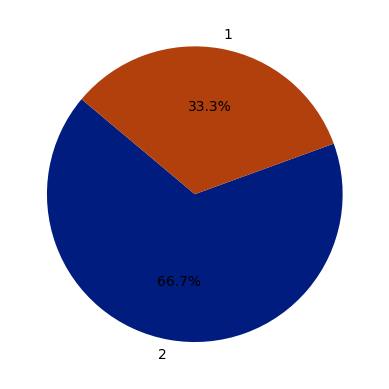

In [110]:
vendor = combined_df['VendorID'].value_counts().reset_index()
vendor.rename(columns={'index': 'VendorID'}, inplace=True)  # Rename the column 'index' to 'VendorID'
color = sns.color_palette('dark')
plt.pie(vendor['VendorID'], labels=vendor['VendorID'], colors=color, autopct='%1.1f%%', startangle=140)


### 2. Rate Code

In [100]:
combined_df['RatecodeID'].value_counts()

RatecodeID
1.0    715649
5.0     22179
2.0      2447
3.0       321
4.0       141
Name: count, dtype: int64

   RatecodeID   count
0         1.0  715649
1         5.0   22179
2         2.0    2447
3         3.0     321
4         4.0     141


Text(0.5, 1.0, 'Rate Code')

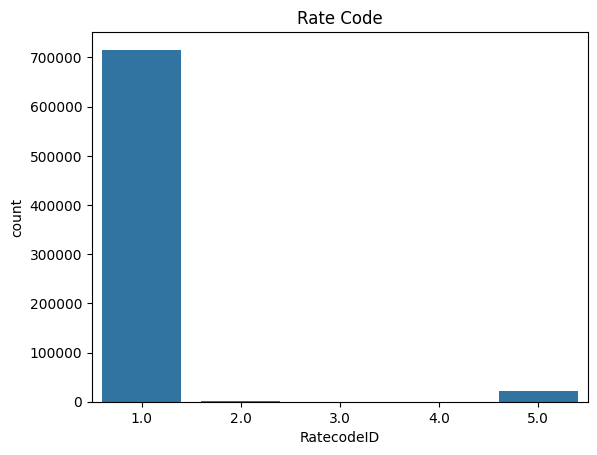

In [101]:
print(combined_df['RatecodeID'].value_counts().reset_index())
rate_code = combined_df['RatecodeID'].value_counts().reset_index()
explode = [0, 0, 0, 1, 2]
# plt.pie(rate_code['RatecodeID'], labels=rate_code['index'], colors=color, autopct='%1.1f%%', startangle=180, explode=explode)
sns.countplot(x='RatecodeID', data=combined_df)
plt.title("Rate Code")


### 3. Hourly Distribution of Trip Counts

Text(0.5, 1.0, 'Hourly Distribution of Trip Counts')

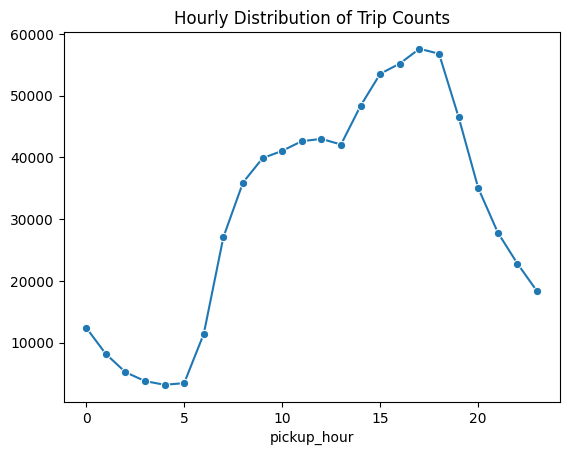

In [104]:
hourly_distribution = combined_df['pickup_hour'].value_counts().sort_index()
sns.lineplot(x=hourly_distribution.index, y=hourly_distribution.values, marker='o')
plt.title("Hourly Distribution of Trip Counts")


### 4. Trip Distance

count    740737.000000
mean          2.997302
std           2.948287
min           0.010000
25%           1.280000
50%           2.030000
75%           3.600000
max          95.500000
Name: trip_distance, dtype: float64


<Axes: xlabel='trip_distance'>

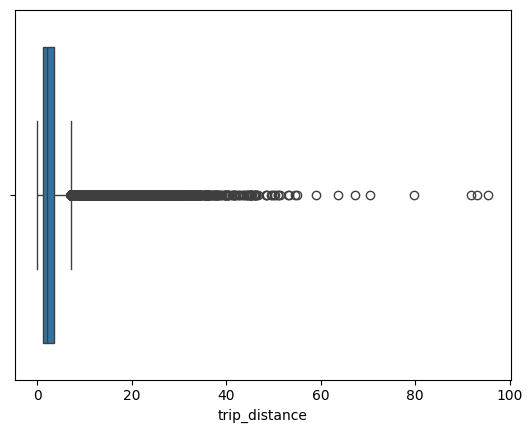

In [112]:
print(combined_df['trip_distance'].describe())
sns.boxplot(x = combined_df['trip_distance'],orient = 'h')

### 5. Fare Amount

count    740737.000000
mean         13.822768
std          11.312454
min           3.500000
25%           7.500000
50%          10.500000
75%          16.000000
max         499.000000
Name: fare_amount, dtype: float64


<Axes: xlabel='fare_amount'>

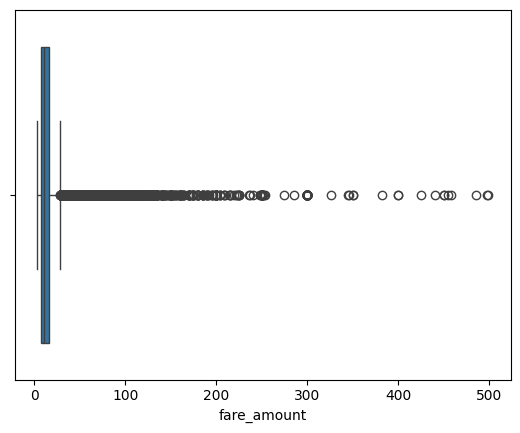

In [113]:
print(combined_df['fare_amount'].describe())
sns.boxplot(combined_df['fare_amount'],orient = 'h')

### 6. Trip Time

count    740737.000000
mean         14.953037
std          11.874643
min           1.020000
25%           7.750000
50%          11.970000
75%          18.320000
max         178.550000
Name: trip_time, dtype: float64


<Axes: xlabel='trip_time'>

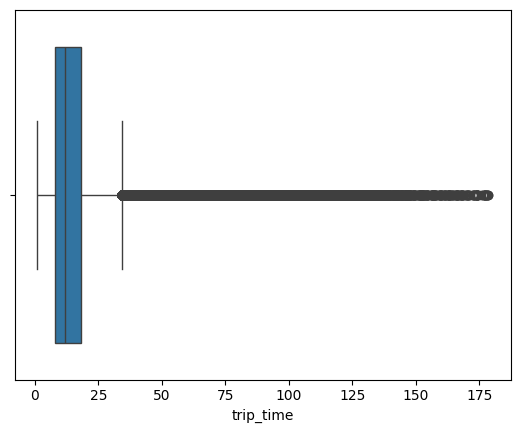

In [114]:
print(combined_df['trip_time'].describe())
sns.boxplot(x = combined_df['trip_time'])

### 7. Tip Amount

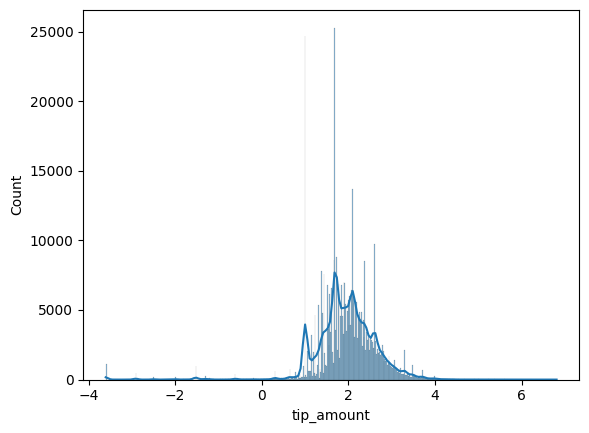

In [115]:
sns.histplot(np.log(combined_df['tip_amount'])+1, kde=True)
plt.show()

### 8. Total Amount

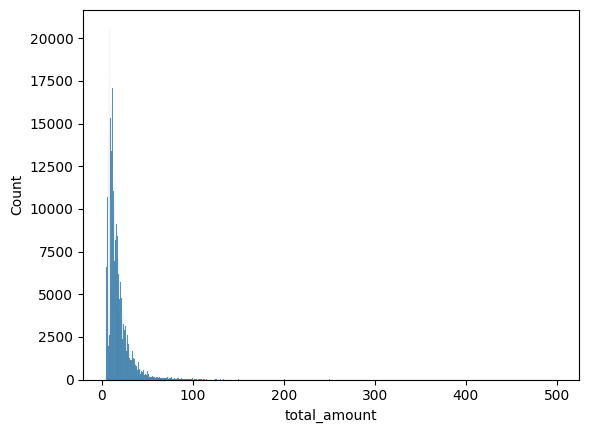

In [116]:
sns.histplot(combined_df['total_amount'])
plt.show()

### 9. Trip distribution by Day

In [117]:
print(combined_df['pickup_dayofweek'].value_counts())

pickup_dayofweek
3    117543
2    114668
4    114479
1    111195
0    103797
5     96623
6     82432
Name: count, dtype: int64


Text(0.5, 1.0, 'Trip distribution by Day')

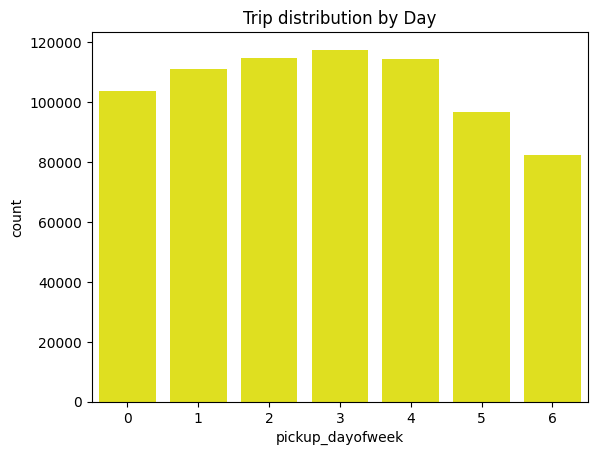

In [119]:
sns.countplot(x='pickup_dayofweek', data=combined_df, color='yellow')
plt.title('Trip distribution by Day')

### 11. Number of Trips by Pickup LocationID

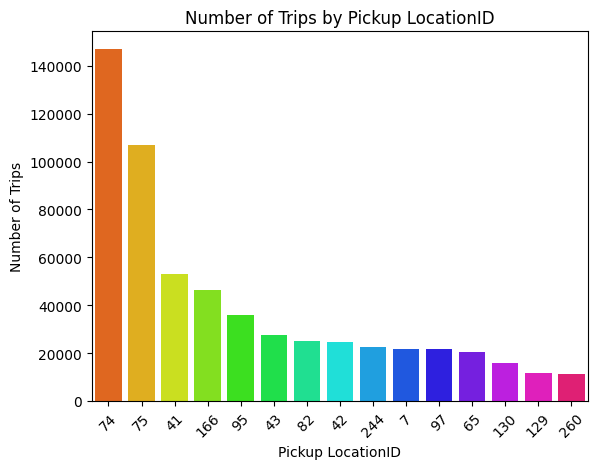

In [122]:
# Defining a color palette
palette = sns.color_palette("hsv", 15)  # Using a palette with 15 distinct colors

# Plotting the count plot with the specified color palette
sns.countplot(x='PULocationID', data=combined_df, order=combined_df['PULocationID'].value_counts().iloc[:15].index, palette=palette)
plt.title('Number of Trips by Pickup LocationID')
plt.xlabel('Pickup LocationID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

### 12. Dropoff LocationID

In [123]:
print(combined_df["drop_zone"].value_counts().head(15))

drop_zone
East Harlem North        40447
East Harlem South        37076
Central Harlem           31139
Central Harlem North     29918
Upper East Side North    29289
Upper West Side North    26841
Morningside Heights      25100
Yorkville West           18687
Manhattan Valley         17597
Upper West Side South    16846
LaGuardia Airport        16735
Central Park             13768
Forest Hills             13516
Hamilton Heights         12453
Upper East Side South    11953
Name: count, dtype: int64


    DOLocationID              drop_zone  count
0             74      East Harlem North  40447
1             75      East Harlem South  37076
2             41         Central Harlem  31139
3             42   Central Harlem North  29918
4            236  Upper East Side North  29289
5            238  Upper West Side North  26841
6            166    Morningside Heights  25100
7            263         Yorkville West  18687
8            151       Manhattan Valley  17597
9            239  Upper West Side South  16846
10           138      LaGuardia Airport  16735
11            43           Central Park  13768
12            95           Forest Hills  13516
13           116       Hamilton Heights  12453
14           237  Upper East Side South  11953


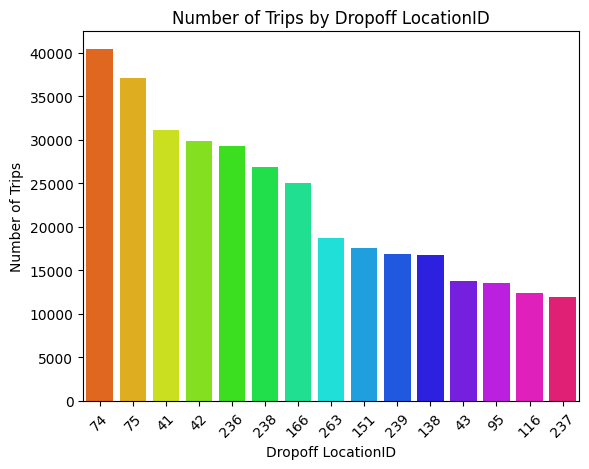

In [127]:
# Defining a color palette
palette = sns.color_palette("hsv", 15)  # Using a palette with 15 distinct colors

print(combined_df[["DOLocationID","drop_zone"]].value_counts().reset_index().head(15))
# Plotting the count plot with the specified color palette
sns.countplot(x='DOLocationID', data=combined_df, order=combined_df['DOLocationID'].value_counts().iloc[:15].index, palette=palette)
plt.title('Number of Trips by Dropoff LocationID')
plt.xlabel('Dropoff LocationID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()


### 13. Distance VS Fare Amount

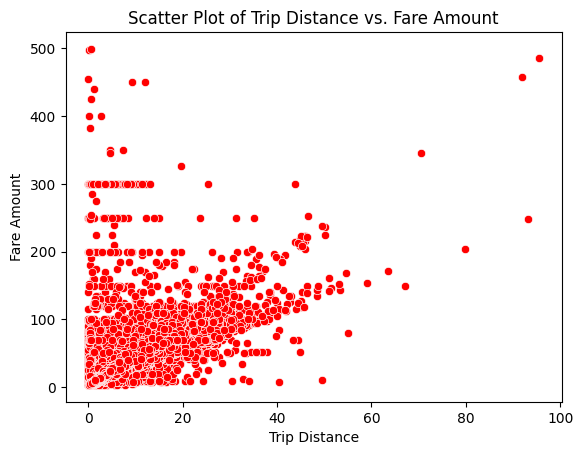

In [130]:
sns.scatterplot(x='trip_distance', y='fare_amount', data=combined_df, color='red')
plt.title('Scatter Plot of Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

### 14. Distance VS Pickup Hour

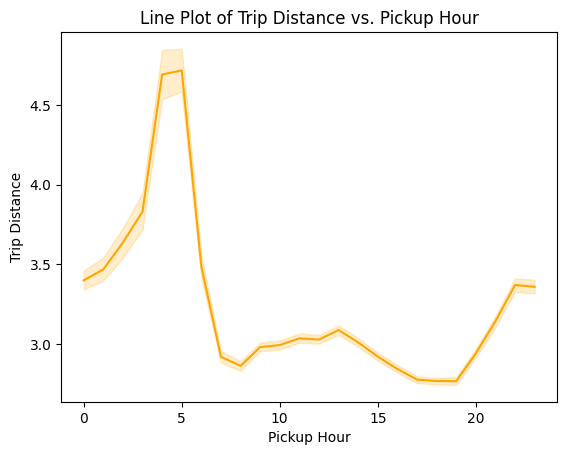

In [131]:
sns.lineplot(x='pickup_hour', y='trip_distance', data=combined_df, color='orange')
plt.title('Line Plot of Trip Distance vs. Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Trip Distance')
plt.show()

### 15. Fare Amount VS Week Day

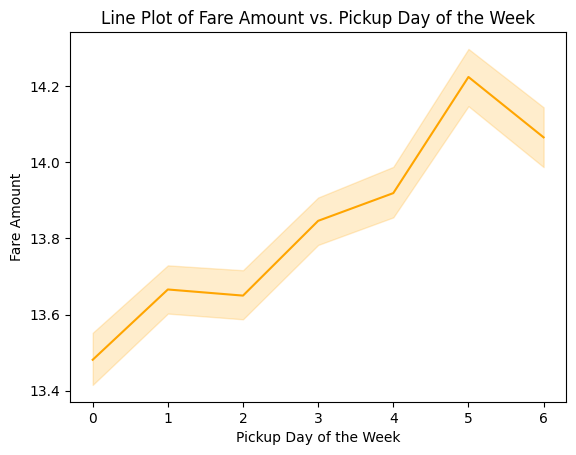

In [133]:
sns.lineplot(x='pickup_dayofweek', y='fare_amount', data=combined_df, color='orange')
plt.title('Line Plot of Fare Amount vs. Pickup Day of the Week')
plt.xlabel('Pickup Day of the Week')
plt.ylabel('Fare Amount')
plt.show()

### 16. Tip Amount VS Pickup Hours

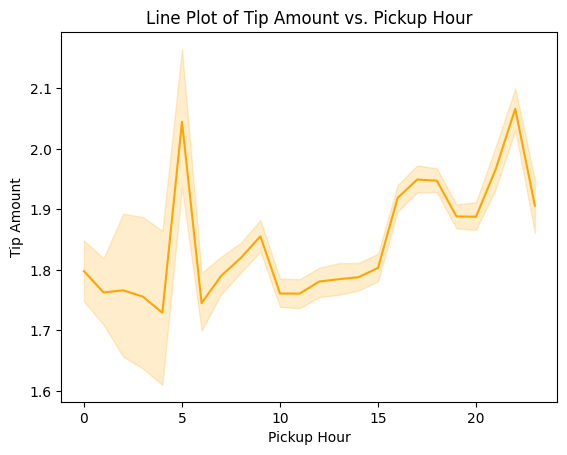

In [135]:
sns.lineplot(x='pickup_hour', y='tip_amount', data=combined_df, color='orange')
plt.title('Line Plot of Tip Amount vs. Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Tip Amount')
plt.show()

### 17. Tip Amount VS Week Day

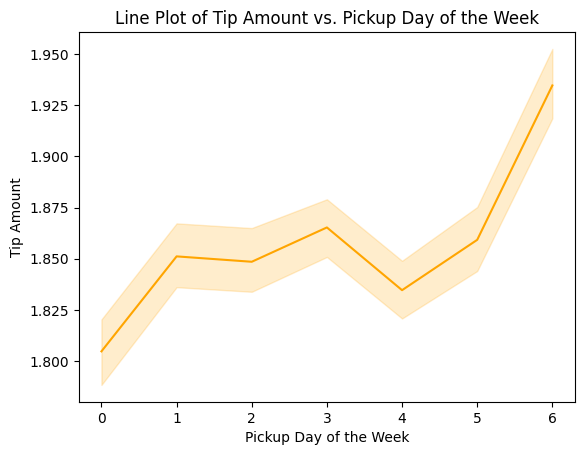

In [136]:
sns.lineplot(x='pickup_dayofweek', y='tip_amount', data=combined_df, color='orange')
plt.title('Line Plot of Tip Amount vs. Pickup Day of the Week')
plt.xlabel('Pickup Day of the Week')
plt.ylabel('Tip Amount')
plt.show()

### 18. Corealtion Matrix

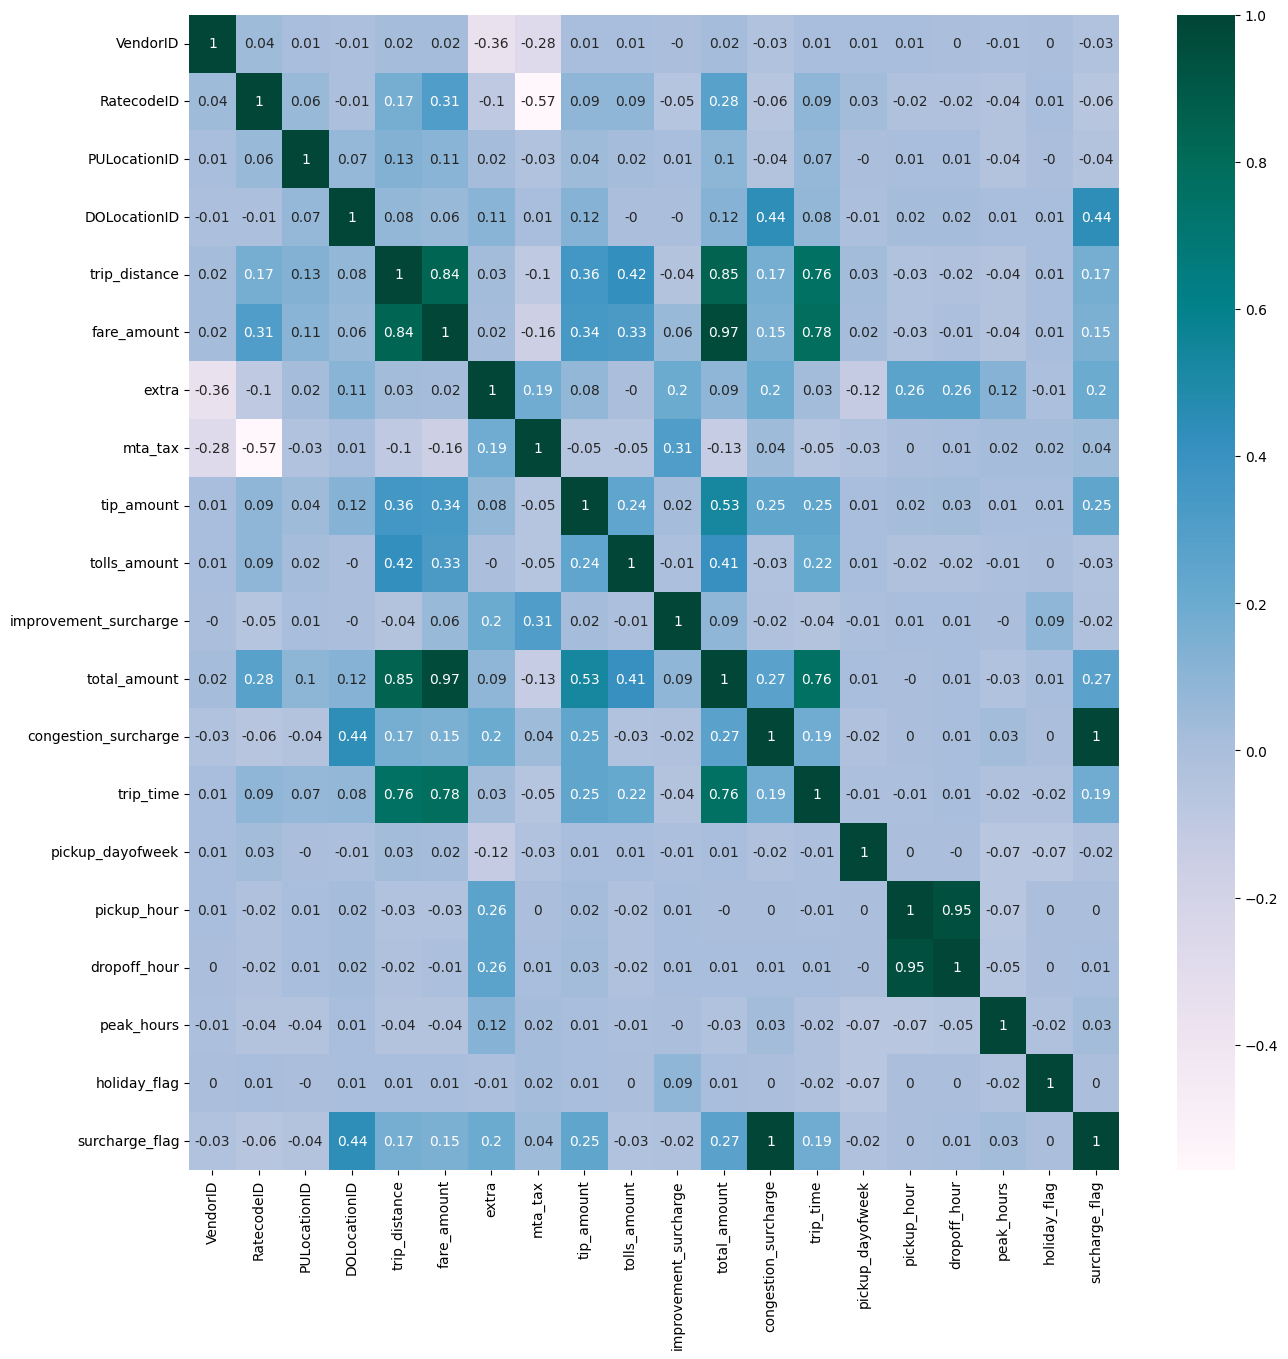

In [138]:
# Select only numeric columns for correlation calculation
numeric_cols = combined_df.select_dtypes(include=['number'])

# Plotting the correlation heatmap with numeric columns
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(round(numeric_cols.corr(), 2), annot=True, cmap='PuBuGn')
plt.show()


In [142]:
# Select only numeric columns for correlation calculation
numeric_cols = combined_df.select_dtypes(include=['number'])

# Print correlation matrix
print(numeric_cols.corr())


                       VendorID  RatecodeID  PULocationID  DOLocationID  \
VendorID               1.000000    0.042400      0.007977     -0.008292   
RatecodeID             0.042400    1.000000      0.062131     -0.009395   
PULocationID           0.007977    0.062131      1.000000      0.070855   
DOLocationID          -0.008292   -0.009395      0.070855      1.000000   
trip_distance          0.015581    0.171415      0.125731      0.076947   
fare_amount            0.022609    0.313235      0.108572      0.062716   
extra                 -0.361728   -0.100214      0.020171      0.111086   
mta_tax               -0.276030   -0.570179     -0.034307      0.009238   
tip_amount             0.011730    0.094596      0.036762      0.116148   
tolls_amount           0.006849    0.085594      0.022106     -0.001958   
improvement_surcharge -0.000952   -0.046622      0.005404     -0.003018   
total_amount           0.020183    0.277541      0.099695      0.119307   
congestion_surcharge  -0.

In [143]:
combined_df.head()

,VendorID,RatecodeID,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,drop_borough,drop_zone,drop_service_zone,trip_time,pickup_dayofweek,pickup_hour,dropoff_hour,peak_hours,holiday_flag,surcharge_flag
0,2,1.0,42,42,0.44,3.5,0.50,0.5,0.00,0.0,...,Manhattan,Central Harlem North,Boro Zone,1.20,5,0,0,0,1,0
1,1,1.0,116,41,2.10,9.5,0.50,0.5,0.00,0.0,...,Manhattan,Central Harlem,Boro Zone,8.72,5,0,0,0,1,0
2,1,1.0,41,140,3.70,14.5,3.25,0.5,4.60,0.0,...,Manhattan,Lenox Hill East,Yellow Zone,16.20,5,0,1,0,1,1
3,2,1.0,181,181,1.69,8.0,0.50,0.5,0.00,0.0,...,Brooklyn,Park Slope,Boro Zone,8.25,5,0,0,0,1,0
4,2,1.0,33,170,6.26,22.0,0.50,0.5,5.21,0.0,...,Manhattan,Murray Hill,Yellow Zone,21.03,5,0,0,0,1,1


## Splitting Dataset to Test-Train

In [144]:
combined_df.columns

Index(['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'pickup_borough', 'pickup_zone',
       'pickup_service_zone', 'drop_borough', 'drop_zone', 'drop_service_zone',
       'trip_time', 'pickup_dayofweek', 'pickup_hour', 'dropoff_hour',
       'peak_hours', 'holiday_flag', 'surcharge_flag'],
      dtype='object')

### 1. Price Prediction

In [145]:
combined_df.pickup_service_zone.unique()

array(['Boro Zone', 'Yellow Zone', 'Airports', 'EWR'], dtype=object)

In [146]:
# Assigning 'fare_amount' as the target variable (y) and the rest of the columns as features (X)
y = combined_df['fare_amount']
X = combined_df.drop(columns=['fare_amount', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'drop_borough', 'drop_zone', 'drop_service_zone'])
#X = X.drop(columns=['RatecodeID','trip_distance','extra', 'mta_tax', 'tip_amount','tolls_amount', 'improvement_surcharge', 'total_amount','congestion_surcharge','trip_time', 'dropoff_hour','surcharge_flag'])
# Encoding categorical variables using one-hot encoding
print(X.columns)
X = pd.get_dummies(X, columns=['VendorID', 'peak_hours', 'holiday_flag', 'pickup_dayofweek', 'pickup_hour'])

# Splitting the data into training and testing sets with a 60-40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


Index(['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'trip_distance', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'trip_time', 'pickup_dayofweek', 'pickup_hour', 'dropoff_hour',
       'peak_hours', 'holiday_flag', 'surcharge_flag'],
      dtype='object')


[0.60283341 0.96334415 0.99194421 0.99593724 0.99872559 0.9991907
 0.99941397 0.9995529  0.99963847 0.99970743 0.99975879 0.99979792
 0.99981681 0.99983297 0.99984884 0.99986438 0.99987927 0.99989254
 0.99990415 0.99991205 0.99991933 0.99992642 0.99993319 0.99993957
 0.9999455  0.99995135 0.99995697 0.99996234 0.99996742 0.99997229
 0.99997664 0.99998072 0.99998469 0.99998808 0.9999908  0.99999344
 0.99999505 0.99999634 0.99999743 0.99999828 0.99999887 0.99999936
 0.99999981 1.         1.         1.         1.         1.
 1.         1.         1.        ]


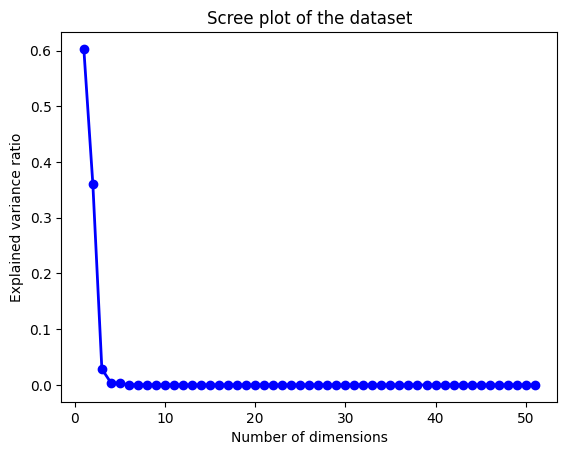

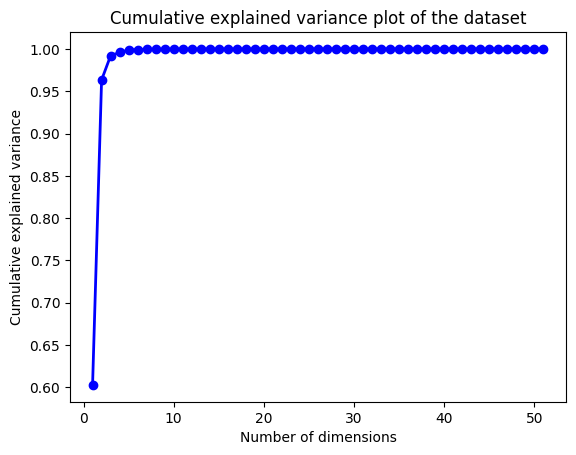

Here are the components
[[-7.19958537e-06  1.36744083e-01  9.90210323e-01  3.54837425e-03
   1.17153544e-03  8.12455823e-06  4.15351887e-03  2.59402486e-05
  -2.36603519e-06  2.26782875e-02  7.04776262e-03  1.34496360e-02
   1.37759771e-03  2.56297691e-03  3.00134061e-05 -3.00134061e-05
  -1.21038334e-05  1.21038334e-05 -9.98714675e-06  9.98714675e-06
   3.64730583e-05  2.77808120e-05  1.10951415e-05 -1.81854548e-05
  -5.23591745e-05 -4.42445344e-05  3.94401519e-05 -3.95098979e-06
  -8.68536856e-06 -7.95788730e-06 -3.87797086e-06  2.46327047e-07
   4.49552244e-06 -2.61008560e-05 -5.66364638e-05 -3.22400736e-05
   1.85489153e-05  1.07001432e-05  1.52226865e-05  2.00919413e-05
  -8.26134029e-06 -6.98927193e-06 -1.10863716e-05  5.65082592e-06
   1.30603263e-05  3.06546663e-05  2.80163199e-05  1.45397689e-05
   1.27608742e-05  5.25753654e-06 -1.34592600e-05]
 [ 7.40765933e-04  9.90240283e-01 -1.37356542e-01  5.80950831e-03
   1.16206429e-05 -8.69763987e-05  9.13540539e-04  4.33233508e-04
 

In [147]:
# Perform PCA on the dataset and calculate the explained variance ratio
pca = PCA(n_components=X.shape[1])  # Define PCA with the number of components equal to the number of features
pca.fit(X)  # Fit PCA to the dataset
explained_variance_ratio = pca.explained_variance_ratio_  # Get explained variance ratio

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Display the cumulative explained variance
print(cumulative_explained_variance)

# Visualize the scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', linewidth=2)
plt.xlabel('Number of dimensions')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot of the dataset')
plt.show()

# Visualize the cumulative explained variance plot
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'bo-', linewidth=2)
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance plot of the dataset')
plt.show()

# Define PCA with 3 components
pca = PCA(n_components=3)
# Fit PCA to the training data
pca.fit(X_train)
print("Here are the components")
print(pca.components_)

# Transform the training and test data using PCA
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [148]:
# Assuming pca.components_ contains the output you provided
components_data = pd.DataFrame(pca.components_, columns=X_train.columns)

# Display the top contributing features for each principal component
for i, component in enumerate(components_data.iterrows()):
    top_features = component[1].abs().sort_values(ascending=False).head(5)
    print(f"\nTop features for Principal Component {i + 1}:\n{top_features}")




Top features for Principal Component 1:
DOLocationID            0.990210
PULocationID            0.136744
total_amount            0.022678
trip_time               0.013450
congestion_surcharge    0.007048
Name: 0, dtype: float64

Top features for Principal Component 2:
PULocationID     0.990240
DOLocationID     0.137357
total_amount     0.018609
trip_time        0.012984
trip_distance    0.005810
Name: 1, dtype: float64

Top features for Principal Component 3:
total_amount     0.740459
trip_time        0.649756
trip_distance    0.150473
tip_amount       0.069159
PULocationID     0.026558
Name: 2, dtype: float64


## Modeling

In [149]:
def tuned_linear_regression(X_train, y_train, X_test, y_test, param_grid=None):
    lm = LinearRegression()
    # set up the parameter grid for hyperparameter tuning
    if param_grid is None:
        param_grid = {'fit_intercept': [None, True, False]}

    # perform grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(lm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)  # Use X_train and y_train directly

    # make predictions on the test set using the best model
    best_lm = grid_search.best_estimator_
    y_pred = best_lm.predict(X_test)

    #display performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    k = X_train.shape[1]  # Adjust k for the number of features used
    adj_r_squared = 1 - (1-r2)*(n-1)/(n-k-1)
    mae = mean_absolute_error(y_test, y_pred)
    print("Best Parameters:", grid_search.best_params_)
    print('Mean Squared Error:', mse)
    print('R-squared:', r2)
    print('Adjusted R-squared:', adj_r_squared)  # Use adjusted R-squared calculated from X_train
    print('Mean Absolute Error:', mae)
    print('Predicted Prices:', y_pred)
    print('Actual Prices:', y_test.head(3))

# Call the function with combined_df data
tuned_linear_regression(X_train_pca, y_train, X_test_pca, y_test)


Best Parameters: {'fit_intercept': True}
Mean Squared Error: 14.013207900930462
R-squared: 0.8917370282371428
Adjusted R-squared: 0.8917359320549595
Mean Absolute Error: 1.7123544900549081
Predicted Prices: [ 8.98870769 14.26365123 26.25287619 ... 17.32609088 25.91373652
 15.74553768]
Actual Prices: 701533    10.7
320794    12.0
140892    26.5
Name: fare_amount, dtype: float64


In [150]:
def tuned_decisiontree_regression(X_train, y_train, X_test, y_test, param_grid=None):
    dtr_model = DecisionTreeRegressor()
    # set up the parameter grid for hyperparameter tuning
    if param_grid is None:
        param_grid = {'max_depth': [3, 5, 7],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [None, 'sqrt', 'log2'],
                        'criterion': ['mse', 'friedman_mse', 'mae']}

    # perform grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(dtr_model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)  # Use X_train and y_train directly

    # make predictions on the test set using the best model
    best_dt = grid_search.best_estimator_
    y_pred = best_dt.predict(X_test)

    #display performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    k = X_train.shape[1]  # Adjust k for the number of features used
    adj_r_squared = 1 - (1-r2)*(n-1)/(n-k-1)
    mae = mean_absolute_error(y_test, y_pred)
    print("Best Parameters:", grid_search.best_params_)
    print('Mean Squared Error:', mse)
    print('R-squared:', r2)
    print('Adjusted R-squared:', adj_r_squared)  # Use adjusted R-squared calculated from X_train
    print('Mean Absolute Error:', mae)
    print('Predicted Prices:', y_pred)
    print('Actual Prices:', y_test.head(3))

# Call the function with combined_df data
tuned_decisiontree_regression(X_train_pca, y_train, X_test_pca, y_test)


Best Parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4}
Mean Squared Error: 11.488722187131078
R-squared: 0.9112406513533496
Adjusted R-squared: 0.9112397526488802
Mean Absolute Error: 1.6131314129950602
Predicted Prices: [ 9.16967329 15.38055597 25.53525552 ... 15.38122397 27.24439769
 14.79724746]
Actual Prices: 701533    10.7
320794    12.0
140892    26.5
Name: fare_amount, dtype: float64


In [151]:
def tuned_KNN_regression(X_train, y_train, X_test, y_test, param_grid=None):
    knn_model = KNeighborsRegressor()
    # set up the parameter grid for hyperparameter tuning
    if param_grid is None:
        param_grid = {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}

    # perform grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(knn_model, param_grid, cv=2)
    grid_search.fit(X_train, y_train)  # Use X_train and y_train directly

    # make predictions on the test set using the best model
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)

    #display performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    k = X_train.shape[1]  # Adjust k for the number of features used
    adj_r_squared = 1 - (1-r2)*(n-1)/(n-k-1)
    mae = mean_absolute_error(y_test, y_pred)
    print("Best Parameters:", grid_search.best_params_)
    print('Mean Squared Error:', mse)
    print('R-squared:', r2)
    print('Adjusted R-squared:', adj_r_squared)  # Use adjusted R-squared calculated from X_train
    print('Mean Absolute Error:', mae)
    print('Predicted Prices:', y_pred)
    print('Actual Prices:', y_test.head(3))

# Call the function with combined_df data
tuned_KNN_regression(X_train_pca, y_train, X_test_pca, y_test)


Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
Mean Squared Error: 9.949146109286563
R-squared: 0.9231350785695036
Adjusted R-squared: 0.9231343002982625
Mean Absolute Error: 1.2429028515712706
Predicted Prices: [ 9.71107749 14.23033029 23.97594865 ... 16.01436175 25.77992731
 13.68252095]
Actual Prices: 701533    10.7
320794    12.0
140892    26.5
Name: fare_amount, dtype: float64


In [152]:
## Lasso Regression:
def tuned_lasso_regression(X_train, y_train, X_test, y_test, param_grid=None):
    lasso_model = Lasso()
    # set up the parameter grid for hyperparameter tuning
    if param_grid is None:
        param_grid = {'alpha': [0.001, 0.01, 0.01838973299508956, 0.1, 1, 10]}

    # perform grid search cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(lasso_model, param_grid, cv=3)
    grid_search.fit(X_train, y_train)  # Use X_train and y_train directly, not X_train_pca

    # make predictions on the test set using the best model
    best_lasso = grid_search.best_estimator_
    y_pred = best_lasso.predict(X_test)

    #display performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    k = X_train.shape[1]  # Number of features in X_train
    adj_r_squared = 1 - (1-r2)*(n-1)/(n-k-1)
    mae = mean_absolute_error(y_test, y_pred)
    print("Best Parameters:", grid_search.best_params_)
    print('Mean Squared Error:', mse)
    print('R-squared:', r2)
    print('Adjusted R-squared:', adj_r_squared)  # Use adjusted R-squared calculated based on the original number of features
    print('Mean Absolute Error:', mae)
    print('Predicted Prices:', y_pred)
    print('Actual Prices:', y_test.head(3))

# Call the tuned_lasso_regression function with combined_df data
tuned_lasso_regression(X_train, y_train, X_test, y_test)


Best Parameters: {'alpha': 0.001}
Mean Squared Error: 0.10310616341109131
R-squared: 0.9992034243881296
Adjusted R-squared: 0.9992032872528852
Mean Absolute Error: 0.19429700211530093
Predicted Prices: [10.80816152 11.9848582  26.60275894 ... 14.62297853 35.50673241
 13.49702169]
Actual Prices: 701533    10.7
320794    12.0
140892    26.5
Name: fare_amount, dtype: float64
